In [ ]:
import os
import torch
from torch import nn
from torch.utils.data import DataLoader
from torchaudio import load, transforms
from scipy.io import wavfile
import matplotlib.pyplot as plt
import librosa
import numpy as np

import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchaudio
import sys

import IPython.display as ipd
import csv

In [ ]:
f = open('./DataANN+MFCC+SVD_loss.csv', 'w')
ff = open('./DataANN+MFCC+SVD_acc.csv', 'w')

# create the csv writer
lossLog = csv.writer(f)
accLog = csv.writer(ff)

# write a row to the csv file
lossLog.writerow(["epoch", "loss"])
accLog.writerow(["epoch", "acc"])


11

In [ ]:
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using {device} device")

Using cuda device


In [ ]:
# IMPORT DATASET
from torchaudio.datasets import SPEECHCOMMANDS
import os


class SubsetSC(SPEECHCOMMANDS):
    def __init__(self, subset: str = None):
        super().__init__("./", download=True)

        def load_list(filename):
            filepath = os.path.join(self._path, filename)
            with open(filepath) as fileobj:
                return [os.path.normpath(os.path.join(self._path, line.strip())) for line in fileobj]

        if subset == "validation":
            self._walker = load_list("validation_list.txt")
        elif subset == "testing":
            self._walker = load_list("testing_list.txt")
        elif subset == "training":
            excludes = load_list("validation_list.txt") + load_list("testing_list.txt")
            excludes = set(excludes)
            self._walker = [w for w in self._walker if w not in excludes]


# Create training and testing split of the data. We do not use validation in this tutorial.
train_set = SubsetSC("training")
test_set = SubsetSC("testing")

waveform, sample_rate, label, speaker_id, utterance_number = train_set[0]

Shape of waveform: torch.Size([1, 16000])
Sample rate of waveform: 16000


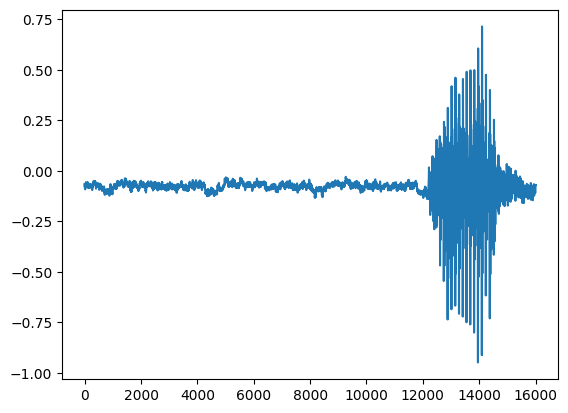

In [ ]:
print("Shape of waveform: {}".format(waveform.size()))
print("Sample rate of waveform: {}".format(sample_rate))

plt.plot(waveform.t().numpy());

In [ ]:
labels = sorted(list(set(datapoint[2] for datapoint in train_set)))
labels

['backward',
 'bed',
 'bird',
 'cat',
 'dog',
 'down',
 'eight',
 'five',
 'follow',
 'forward',
 'four',
 'go',
 'happy',
 'house',
 'learn',
 'left',
 'marvin',
 'nine',
 'no',
 'off',
 'on',
 'one',
 'right',
 'seven',
 'sheila',
 'six',
 'stop',
 'three',
 'tree',
 'two',
 'up',
 'visual',
 'wow',
 'yes',
 'zero']

In [ ]:
# module transform ubtuk mengubah data suara menjadi MFCC dan dimensionality reduction dengan SVD
class MFCC_SVD(nn.Module):
    def __init__(self, out_channels = 20):
        super().__init__()
        self.out_channels = out_channels
        self.mfcc = transforms.MFCC(sample_rate=16000)
    def forward(self, waveform):
        mfcc_signal = self.mfcc(waveform)
        if mfcc_signal.shape[1] == 1:
            mfcc_signal = torch.squeeze(mfcc_signal)
        if mfcc_signal.shape[-1] > self.out_channels:
            U, S, _ = torch.linalg.svd(mfcc_signal)
            S = torch.diag_embed(S[:, :self.out_channels])
            out = torch.bmm(U[:, :, :self.out_channels], S)
        return out

In [ ]:
transform = MFCC_SVD()
transformed = transform(waveform)
print(transformed.shape)
# MFCC and SVD final feature

torch.Size([1, 40, 20])


/opt/conda/envs/sainskom/lib/python3.10/site-packages/torchaudio/functional/functional.py:576: UserWarning: At least one mel filterbank has all zero values. The value for `n_mels` (128) may be set too high. Or, the value for `n_freqs` (201) may be set too low.
  warnings.warn(


In [ ]:
def label_to_index(word):
    # Return the position of the word in labels
    return torch.tensor(labels.index(word))


def index_to_label(index):
    # Return the word corresponding to the index in labels
    # This is the inverse of label_to_index
    return labels[index]


word_start = "yes"
index = label_to_index(word_start)
word_recovered = index_to_label(index)

print(word_start, "-->", index, "-->", word_recovered)

yes --> tensor(33) --> yes


In [ ]:
def pad_sequence(batch):
    # Make all tensor in a batch the same length by padding with zeros
    batch = [item.t() for item in batch]
    batch = torch.nn.utils.rnn.pad_sequence(batch, batch_first=True, padding_value=0.)
    return batch.permute(0, 2, 1)


def collate_fn(batch):

    # A data tuple has the form:
    # waveform, sample_rate, label, speaker_id, utterance_number

    tensors, targets = [], []

    # Gather in lists, and encode labels as indices
    for waveform, _, label, *_ in batch:
        tensors += [waveform]
        targets += [label_to_index(label)]

    # Group the list of tensors into a batched tensor
    tensors = pad_sequence(tensors)
    targets = torch.stack(targets)

    return tensors, targets


batch_size = 256

if device == "cuda":
    num_workers = 1
    pin_memory = True
else:
    num_workers = 0
    pin_memory = False

train_loader = torch.utils.data.DataLoader(
    train_set,
    batch_size=batch_size,
    shuffle=True,
    collate_fn=collate_fn,
    num_workers=num_workers,
    pin_memory=pin_memory,
)
test_loader = torch.utils.data.DataLoader(
    test_set,
    batch_size=batch_size,
    shuffle=False,
    drop_last=False,
    collate_fn=collate_fn,
    num_workers=num_workers,
    pin_memory=pin_memory,
)

In [ ]:
# ANN Architecture
class NeuralNetwork(nn.Module):
    def __init__(self, n_input, n_output):
        super().__init__()
        self.flatten = nn.Flatten()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(n_input, 512),
            nn.ReLU(),
            nn.Linear(512, 512),
            nn.ReLU(),
            nn.Linear(512, n_output),
        )

    def forward(self, x):
        x = self.flatten(x)
        out = self.linear_relu_stack(x)
        return out

model = NeuralNetwork(n_input=transformed.shape[1] * transformed.shape[2], n_output=len(labels))
model.to(device)
print(model)


def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)


n = count_parameters(model)
print("Number of parameters: %s" % n)

NeuralNetwork(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=800, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=512, bias=True)
    (3): ReLU()
    (4): Linear(in_features=512, out_features=35, bias=True)
  )
)
Number of parameters: 690723


In [ ]:
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=0.0001)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)  # reduce the learning after 20 epochs by a factor of 10
loss_fn = torch.nn.CrossEntropyLoss()

In [ ]:
def train(model, epoch, log_interval):
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):

        data = data.to(device)
        target = target.to(device)
        data = transform(data)

        # apply transform and model on whole batch directly on device
        output = model(data)

        # negative log-likelihood for a tensor of size (batch x 1 x n_output)
        loss = loss_fn(output, target)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # print training stats
        if batch_idx % log_interval == 0:
            print(f"Train Epoch: {epoch} [{batch_idx * len(data)}/{len(train_loader.dataset)} ({100. * batch_idx / len(train_loader):.0f}%)]\tLoss: {loss.item():.6f}")

        # update progress bar
        # pbar.update(pbar_update)
        # record loss
        losses.append(loss.item())
        lossLog.writerow([epoch, loss.item()])

In [ ]:
def number_of_correct(pred, target):
    # count number of correct predictions
    return pred.squeeze().eq(target).sum().item()


def get_likely_index(tensor):
    # find most likely label index for each element in the batch
    return tensor.argmax(dim=-1)


def test(model, epoch):
    model.eval()
    correct = 0
    for data, target in test_loader:

        data = data.to(device)
        target = target.to(device)

        # apply transform and model on whole batch directly on device
        data = transform(data)
        output = model(data)

        pred = get_likely_index(output)
        correct += number_of_correct(pred, target)

        # update progress bar
        # pbar.update(pbar_update)
    accLog.writerow([epoch, correct/len(test_loader.dataset) * 100.])

    print(f"\nTest Epoch: {epoch}\tAccuracy: {correct}/{len(test_loader.dataset)} ({100. * correct / len(test_loader.dataset):.0f}%)\n")

Train Epoch: 1 [0/84843 (0%)]	Loss: 32.763786
Train Epoch: 1 [25600/84843 (30%)]	Loss: 2.438800
Train Epoch: 1 [51200/84843 (60%)]	Loss: 1.978521
Train Epoch: 1 [76800/84843 (90%)]	Loss: 1.744115

Test Epoch: 1	Accuracy: 5502/11005 (50%)

Train Epoch: 2 [0/84843 (0%)]	Loss: 1.531656
Train Epoch: 2 [25600/84843 (30%)]	Loss: 1.372594
Train Epoch: 2 [51200/84843 (60%)]	Loss: 1.544698
Train Epoch: 2 [76800/84843 (90%)]	Loss: 1.559744

Test Epoch: 2	Accuracy: 5955/11005 (54%)

Train Epoch: 3 [0/84843 (0%)]	Loss: 1.078527
Train Epoch: 3 [25600/84843 (30%)]	Loss: 1.068485
Train Epoch: 3 [51200/84843 (60%)]	Loss: 1.109488
Train Epoch: 3 [76800/84843 (90%)]	Loss: 1.291308

Test Epoch: 3	Accuracy: 6275/11005 (57%)

Train Epoch: 4 [0/84843 (0%)]	Loss: 0.826551
Train Epoch: 4 [25600/84843 (30%)]	Loss: 0.930547
Train Epoch: 4 [51200/84843 (60%)]	Loss: 1.030680
Train Epoch: 4 [76800/84843 (90%)]	Loss: 1.047500

Test Epoch: 4	Accuracy: 6399/11005 (58%)

Train Epoch: 5 [0/84843 (0%)]	Loss: 0.701832
Tr

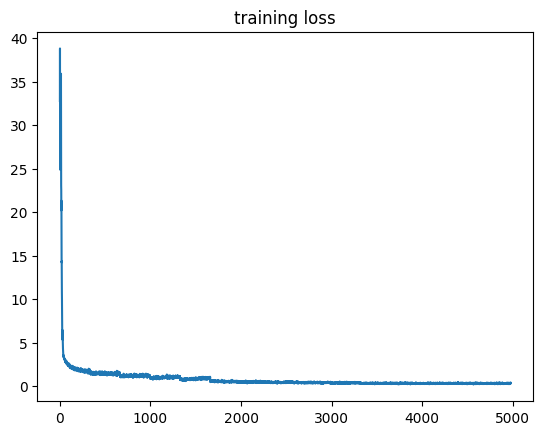

In [ ]:
log_interval = 100
n_epoch = 15

pbar_update = 1 / (len(train_loader) + len(test_loader))
losses = []

# The transform needs to live on the same device as the model and the data.
transform = transform.to(device)
for epoch in range(1, n_epoch + 1):
    train(model, epoch, log_interval)
    test(model, epoch)
    scheduler.step()

# Let's plot the training loss versus the number of iteration.
plt.plot(losses);
plt.title("training loss");